In [6]:
! pip install my-torch
# In case the fancy dict truc doesn't work

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 12.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 133.7 kB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 979.5 kB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.3/913.3 kB 1.9 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 268.1 kB/s eta 0:00:0031m47.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 185.1 kB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 806.6 kB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.1 MB/s eta 0:00:00 eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 313.7 kB/s eta 0:00:0031m62.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 13.1 MB/s eta 0:00:00m eta 0:00:0136m0:00:01


In [22]:
from run import Runner
from mytorch.utils.goodies import FancyDict
from matplotlib import pyplot as plt
import numpy as np

In [13]:
args = {'name' : 'testrun',
'dataset' : 'RezoJDM16k',
'model' : 'compgcn',
'score_func' : 'conve',
'opn' : 'corr',                 
'use_wandb' : False, 
'batch_size' : 128,       
'gamma' : 40.0,			
'gpu' : '0',			
'max_epochs' : 500,  	
'l2' : 0.0,			
'lr' : 0.001,			
'lbl_smooth' : 0.1,	
'num_workers' : 10,                     
'seed' : 41504,     	
'restore' : True,            
'bias' : False   ,         
'num_bases' : -1, 	
'init_dim' : 100,	
'gcn_dim' : 200 ,	
'embed_dim' : None, 	
'gcn_layer' : 1 	,
'dropout' : 0.1	,
'hid_drop' : 0.3	,
'hid_drop2' : 0.3	,
'feat_drop' : 0.3	,
'k_w' : 10 	,
'k_h' : 20 	,
'num_filt' : 200, 	
'ker_sz' : 7 	,
'log_dir' : './log/',               
'config_dir' : './config/'}
args = FancyDict(args)

model = Runner(args)

2023-07-12 16:27:03,004 - [INFO] - {}
2023-07-12 16:27:03,004 - [INFO] - {}
2023-07-12 16:27:03,004 - [INFO] - {}
2023-07-12 16:27:03,004 - [INFO] - {}
{}


In [ ]:
# Now load the saved model
# model.load_model(...)

In [16]:
model.ent2id['connasse'] # Voila ca marche

8914

In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.manifold import TSNE

In [30]:
assert len(model.ent2id) == model.model.init_embed.data.shape[0], "The numbers don't add up, something feels weird"

In [101]:
def visualize(
    model, # Runner object
    words = [], # If None, visualize everything
    words2 = [], # If given, we can color them differently
    use_tsne_not_pca = True, # If False, we use PCA
    label_every_dot = True # Make it false if word lists are too large
):

    if words2 and not words:
        raise ValueError(f'Words is None, and Words2 is not None. Ca marche pas.')
        
    if not words and not words2:
        # we visualize everything
        vecs = model.model.init_embed.data.cpu().numpy()
    else:
        # we visualize a few node vectors
        node_ids = [model.ent2id[word] for word in words]
        if words2:
            node_ids_2 = [model.ent2id[word] for word in words2]
            y = [0]*len(node_ids) + [1]*len(node_ids_2)
        else:
            node_ids_2, y = [], None
        vecs = np.asarray([embeddings[node_id] for node_id in node_ids+node_ids_2])
            
    # Ok we have vectors now. Let's fit
    if use_tsne_not_pca:
        tsne = TSNE(n_components=2, learning_rate='auto', init='random', 
                    perplexity = min(len(words)+len(words2)-1, 50)) 
        z = tsne.fit_transform(vecs)
    else:
        z = PCA().fit_transform(vecs)[:,:2]
        
    # Now to plot everything
    df = pd.DataFrame()
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]
    
    # Case 1: no need for different colors, we just throw the entire thing out.
    if not words2:
        plt = sns.scatterplot(x="comp-1", y="comp-2", palette=sns.color_palette("hls", 3),
                    data=df)
    # Case 2: yes we are comparing two group of words
    else:
        assert y, "y should not be none"
        df["y"] = y
        plt = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df)
    
    plt.set(title=f"{'T-SNE' if use_tsne_not_pca else 'PCA'} projection of Node Vectors") 
    
    # Do we label every dot?
    if label_every_dot and words:
        # Compute x and y offset based on magnitude of vectors
        xo = (df['comp-1']**2).sum()**0.5/len(df['comp-1'])/20
        yo = (df['comp-2']**2).sum()**0.5/len(df['comp-1'])/20
        
        # We have to label at least one set of words.
        for word, (x,y) in zip(words+words2, z):
            plt.text(x+xo, y+yo, word)

/tmp/ipykernel_9297/3617552910.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt = sns.scatterplot(x="comp-1", y="comp-2", palette=sns.color_palette("hls", 3),


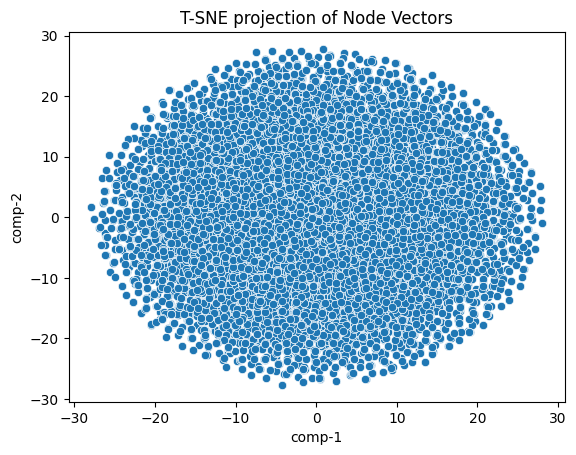

In [94]:
# Visualize everything
visualize(model)

/tmp/ipykernel_9297/1621071938.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt = sns.scatterplot(x="comp-1", y="comp-2", palette=sns.color_palette("hls", 3),


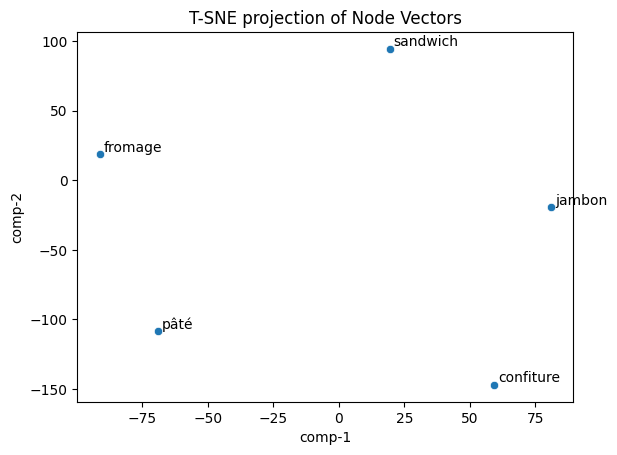

In [102]:
# Visualize one set of words, with labels
words1 = ['confiture', 'jambon', 'sandwich', 'pâté', 'fromage']
visualize(model, words=words1)

/tmp/ipykernel_9297/1621071938.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt = sns.scatterplot(x="comp-1", y="comp-2", palette=sns.color_palette("hls", 3),


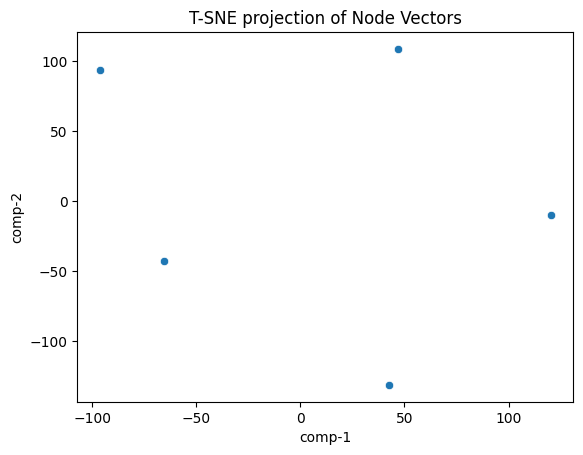

In [103]:
# Visualize one set of words, WITHOUT labels
words1 = ['confiture', 'jambon', 'sandwich', 'pâté', 'fromage']
visualize(model, words=words1, label_every_dot=False)

/tmp/ipykernel_9297/1621071938.py:46: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  plt = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


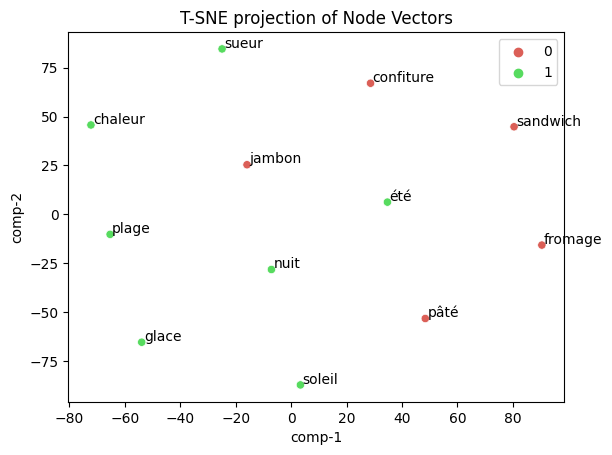

In [104]:
# T-SNE over two set of words
words1 = ['confiture', 'jambon', 'sandwich', 'pâté', 'fromage']
words2 = ['soleil', 'nuit', 'chaleur', 'été', 'sueur', 'glace', 'plage']
visualize(model, words=words1, words2=words2)

/tmp/ipykernel_9297/1621071938.py:46: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  plt = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


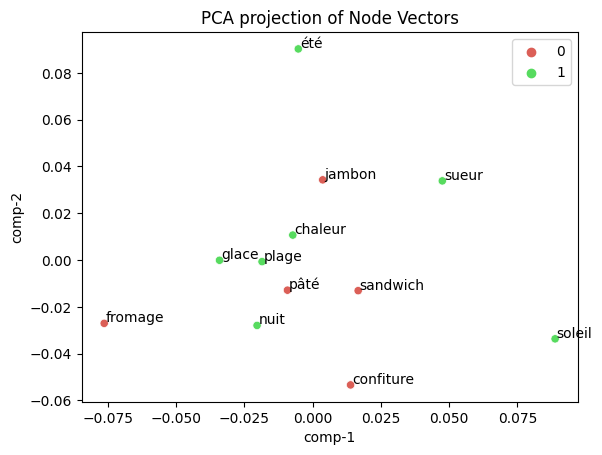

In [105]:
# Same but PCA
# T-SNE over two set of words
words1 = ['confiture', 'jambon', 'sandwich', 'pâté', 'fromage']
words2 = ['soleil', 'nuit', 'chaleur', 'été', 'sueur', 'glace', 'plage']
visualize(model, words=words1, words2=words2, use_tsne_not_pca=False)

In [128]:
from numpy.linalg import norm
from numpy import dot

def cosine(v1, v2):
  """
  cosine similarity of two vectors
  NB: Standard metric to measure similarity between word vectors
  
  Hint: look at the imports in cell above ;)
  """
  return dot(v1, v2)/(norm(v1)*norm(v2))


class NodeVectors:
    
    def __init__(self, vocab, vectors):
        self.vocab = vocab
        self.vectors = vectors
        self._dim = self.vectors.shape[0]
        self.zerovec = np.zeros((self._dim), dtype=float)
        
        self._norm = norm(vectors, axis=1)
        self.id_to_tok = {i:tok for tok, i in vocab.items()}
        
    def safely_vectorize(self, toks):
        return [self.vectors[self.vocab[tok]] for tok in toks if tok in self.vocab]
        
    def __call__(self, k):
        # If token exists 
        if k in self.vocab:
            return self.vectors[self.vocab[k]]
        elif k.lower() in self.vocab:
            return self.vectors[self.vocab[k.lower()]]
        elif k[0].upper()+k[1:].lower() in self.vocab:
            return self.vectors[self.vocab[k[0].upper()+k[1:].lower()]]
        else:
            return self.zerovec
        
    def __len__(self):
        return len(self.vocab)
    
    def most_similar(self, word, k: 10, normalize=True):
        if isinstance(word, str):
            wid = self.vocab.get(word, -1)
            if wid < 0:
                return None
            v = self.vectors[wid]
        elif isinstance(word, np.ndarray) and len(word.shape) == 1:
            v = word
        else:
            raise TypeError(f"Unknown Type of word: {type(word)} ")
            
        cosines = np.dot(self.vectors, v) 
        if normalize:
            cosines = cosines / self._norm / norm(v)
        cosines_ind = np.argsort(-cosines)[:k]
        return [(self.id_to_tok[tokid], cosines[tokid]) for tokid in cosines_ind]
    
    def analogy2(self, wa, wb, wc, k=10):
        if wa in self.vocab and wb in self.vocab and wc in self.vocab:

            diff = self(wa) - self(wb) + self(wc)
            dists = sorted([(tok, float(norm(diff - self.vectors[i]))) for tok, i in self.vocab.items() if not tok in [wa, wb, wc]], key=lambda x: x[1])
            
            return dists[:k]
        else:
            return None
        
    def analogy(self, wa, wb, wc, k=10):
        if wa in self.vocab and wb in self.vocab and wc in self.vocab:

            diff = self(wb) + self(wc) - self(wa)
            dists = sorted([(tok, float(norm(diff - self.vectors[i]))) for tok, i in self.vocab.items() if not tok in [wa, wb, wc]], key=lambda x: x[1])
            
            return dists[:k]
        else:
            return None
        

In [121]:
nvs = NodeVectors(vocab=model.ent2id, vectors=model.model.init_embed.data.cpu().numpy())

In [134]:
# Get vector for one word
nvs('doctorat')

array([-0.0001,  0.0053,  0.0137,  0.009 , -0.0066, -0.0053,  0.01  ,
        0.0199, -0.0074,  0.0077,  0.0048,  0.0018, -0.0096, -0.0004,
       -0.0051,  0.0083,  0.0084,  0.0079,  0.0097,  0.0261,  0.0213,
       -0.0021,  0.0163, -0.0002, -0.0013, -0.007 ,  0.0177, -0.022 ,
        0.0035, -0.0034,  0.0071, -0.0155, -0.0057,  0.0024, -0.0134,
        0.002 , -0.0163, -0.014 ,  0.006 , -0.0108, -0.011 , -0.0013,
       -0.0082,  0.0042,  0.0156,  0.0157,  0.0009, -0.0187, -0.0006,
       -0.0063,  0.0024,  0.0107,  0.0004,  0.0017,  0.0341, -0.0061,
       -0.001 ,  0.0067,  0.0356, -0.0027, -0.0124,  0.0073, -0.0058,
        0.0105, -0.0042,  0.0203, -0.0162, -0.003 , -0.0141,  0.0181,
        0.0055,  0.0086,  0.0009,  0.0046, -0.0107,  0.0039,  0.009 ,
       -0.0144,  0.0001, -0.0005, -0.0043, -0.0023,  0.0152,  0.0026,
       -0.0118, -0.0036,  0.006 ,  0.0141, -0.002 ,  0.0292,  0.0245,
       -0.0053,  0.0129, -0.0035,  0.0032, -0.0017, -0.0006, -0.0095,
       -0.0103,  0.0

In [129]:
# Get cosine between vectors
print(f"Cosine of 'doctorat', and 'inutile' is {cosine(nvs('doctorat'), nvs('inutile')):.4f}")


Cosine of 'doctorat', and 'idiot' is 0.0439


In [135]:
# Similarity 
# 1- computing the cosine between the vector of 'dog' and all the other words
# 2- get the top-10 most similar words 
# most_similar does those two steps 
nvs.most_similar('inutile', 20)



[('inutile', 1.0),
 ('accomplir', 0.34177786),
 ('ouistiti', 0.34110573),
 ('pouilleux', 0.32891443),
 ('drague', 0.32749408),
 ('héron cendré', 0.32513726),
 ('postiche', 0.32189792),
 ('science-fiction', 0.3208566),
 ('déménagement', 0.3197634),
 ('faire un bisou', 0.3195732),
 ('attribut', 0.3157515),
 ('outil', 0.31535998),
 ('pachyderme', 0.31466067),
 ('ordinaire', 0.3117957),
 ('contusion', 0.31150648),
 ('Robert De Niro', 0.31078836),
 ('vente', 0.3097068),
 ('chat persan', 0.3073338),
 ('applaudissement', 0.30326518),
 ('tube', 0.30321106)]